<a href="https://colab.research.google.com/github/jchen42703/earthquake_forecasting/blob/main/notebooks/%5BCatBoost_2%5D_Earthquake_Damage_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Catboost Training

# Setup

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
def download_data(file_id: str, fname: str):
  downloaded = drive.CreateFile({'id': file_id})
  print('Downloaded content "{}"'.format(fname))
  downloaded.GetContentFile(fname) # Download file as fname

# preprocessed train data for catboost ONLY
# download_data("1blCh7V5-juHvd_xCsmNwL6l47vp1dFPr", "cat_train_values.csv")
# # training data
# download_data("1sS2U20IQKhomZvfbCUgG7_hDBEUHYWyH", "train_values.csv")
# training labels
download_data("1s-ebg2xe-4YCO7pjbREWHcZwqiPsT5hY", "train_labels.csv")
# # test data
# download_data("1hkyz1vOg3_hQWiYo-5n-a6eIUuXwjVB0", "test_values.csv")
# # submission_format
download_data("1Ji08vsjUnE06TFvy0rkoIwQobG122r1B", "submission_format.csv")
download_data("1sZdUVw88nFDiaZwDDdfJV-CUZMcGnQ3c", "train_data_embeds.csv")

download_data("1n5liO-i1ajxcRlplBX8-LnTpgdbS505t", "test_data_embeds.csv")

Downloaded content "train_labels.csv"
Downloaded content "submission_format.csv"
Downloaded content "train_data_embeds.csv"
Downloaded content "test_data_embeds.csv"


In [ ]:
!pip install catboost

import catboost
print(catboost.__version__)

     |████████████████████████████████| 76.3 MB 1.3 MB/s 
1.0.3


# CatBoost
https://coderzcolumn.com/tutorials/machine-learning/catboost-an-in-depth-guide-python

https://www.analyseup.com/python-machine-learning/catboost-python-tutorial.html

https://catboost.ai/en/docs/concepts/python-usages-examples#multiclassification



# EDA

In [ ]:
import pandas as pd

X = pd.read_csv("train_data_embeds.csv").drop(["building_id", "Unnamed: 0"], axis=1)
Y = pd.read_csv("train_labels.csv").drop(["building_id"], axis=1)
X

,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,...,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,geo_feat1,geo_feat2,geo_feat3,geo_feat4,geo_feat5,geo_feat6,geo_feat7,geo_feat8,geo_feat9,geo_feat10,geo_feat11,geo_feat12,geo_feat13,geo_feat14,geo_feat15,geo_feat16
0,2,30,6,5,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.008694,-0.627479,-1.932092,-1.352971,1.210723,-0.969630,-1.498751,-0.427753,1.313747,1.043078,2.243259,-0.485953,2.259708,1.000786,1.877474,0.547761
1,2,10,8,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.908526,0.998413,-0.844014,-1.655309,0.578838,-0.159314,0.876370,0.798046,1.537147,1.234688,0.813855,-1.614154,-0.076917,0.125310,1.477580,-1.249146
2,2,10,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1.861815,1.351849,-2.338743,-2.576419,-0.235175,-0.220847,-0.147367,1.463318,1.047525,0.996409,-0.107480,-1.332191,2.034211,2.696030,-0.663659,-1.964653
3,2,10,6,5,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1.378042,1.087642,-2.164048,-0.668801,0.691841,-2.368337,-0.893961,0.917251,1.217506,0.874881,-0.263543,-1.850625,1.617405,-0.379536,-0.808820,-1.665377
4,3,30,8,9,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1.872332,-0.680889,-1.071059,-2.128057,1.872651,-0.998014,-0.548861,2.254541,0.001186,1.148989,1.442763,1.077754,0.544689,2.298833,2.032666,-2.213592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,1,55,6,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.372380,1.075919,0.404362,0.187886,1.331824,-0.270817,0.249597,0.641817,0.734716,0.921014,1.718109,-0.918815,0.526678,1.720652,0.664152,-1.588144
260597,2,0,6,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.014484,-0.708736,-1.343725,-1.667202,0.319017,-2.806258,-1.128338,1.950719,0.041994,1.654622,1.238235,-1.453372,0.381435,-0.364326,1.842740,-2.540284
260598,3,55,6,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0

In [ ]:
X2 = pd.read_csv("train_values.csv").drop(["building_id", "geo_level_1_id", "geo_level_2_id", "geo_level_3_id"], axis=1)
X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 35 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   count_floors_pre_eq                     260601 non-null  int64 
 1   age                                     260601 non-null  int64 
 2   area_percentage                         260601 non-null  int64 
 3   height_percentage                       260601 non-null  int64 
 4   land_surface_condition                  260601 non-null  object
 5   foundation_type                         260601 non-null  object
 6   roof_type                               260601 non-null  object
 7   ground_floor_type                       260601 non-null  object
 8   other_floor_type                        260601 non-null  object
 9   position                                260601 non-null  object
 10  plan_configuration                      260601 non-null 

In [ ]:
X.loc[0][-16:]

geo_feat1     0.008694
geo_feat2    -0.627479
geo_feat3    -1.932092
geo_feat4    -1.352971
geo_feat5     1.210723
geo_feat6    -0.969630
geo_feat7    -1.498751
geo_feat8    -0.427753
geo_feat9     1.313747
geo_feat10    1.043078
geo_feat11    2.243259
geo_feat12   -0.485953
geo_feat13    2.259708
geo_feat14    1.000786
geo_feat15    1.877474
geo_feat16    0.547761
Name: 0, dtype: float64

In [ ]:
import numpy as np
out = []
for i in range(0, len(X)):
    layer_output = X.loc[0][-16:]
    out.append(layer_output)

out = np.array(out)
out

In [ ]:
out = np.array(out)
out.shape

(260601, 16)

In [ ]:
params = {f"geo_feat{idx+1}": out[:, idx] for idx in range(16)}
augmented_df = X2.assign(**params)
augmented_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 51 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   count_floors_pre_eq                     260601 non-null  int64  
 1   age                                     260601 non-null  int64  
 2   area_percentage                         260601 non-null  int64  
 3   height_percentage                       260601 non-null  int64  
 4   land_surface_condition                  260601 non-null  object 
 5   foundation_type                         260601 non-null  object 
 6   roof_type                               260601 non-null  object 
 7   ground_floor_type                       260601 non-null  object 
 8   other_floor_type                        260601 non-null  object 
 9   position                                260601 non-null  object 
 10  plan_configuration                      2606

In [ ]:
augmented_df.to_csv("cat_train_values.csv", index=False)

In [ ]:
new_df = pd.read_csv("cat_train_values.csv")
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 51 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   count_floors_pre_eq                     260601 non-null  int64  
 1   age                                     260601 non-null  int64  
 2   area_percentage                         260601 non-null  int64  
 3   height_percentage                       260601 non-null  int64  
 4   land_surface_condition                  260601 non-null  object 
 5   foundation_type                         260601 non-null  object 
 6   roof_type                               260601 non-null  object 
 7   ground_floor_type                       260601 non-null  object 
 8   other_floor_type                        260601 non-null  object 
 9   position                                260601 non-null  object 
 10  plan_configuration                      2606

In [ ]:
from pandas.api.types import is_numeric_dtype

def get_categorical_indicies(X):
  cats = []
  for col in X.columns:
    if is_numeric_dtype(X[col]):
      pass
    else:
      cats.append(col)
  print(cats)
  cat_indicies = []
  for col in cats:
    cat_indicies.append(X.columns.get_loc(col))
  return cat_indicies

categorical_indicies = get_categorical_indicies(augmented_df)
categorical_indicies

['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']


[4, 5, 6, 7, 8, 9, 10, 22]

In [ ]:
def convert_cats(X):
  cats = []
  for col in X.columns:
    if is_numeric_dtype(X[col]):
      pass
    else:
      cats.append(col)
  cat_indicies = []
  for col in cats:
    X[col] = X[col].astype('category')
    
convert_cats(augmented_df)
augmented_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 51 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   count_floors_pre_eq                     260601 non-null  int64   
 1   age                                     260601 non-null  int64   
 2   area_percentage                         260601 non-null  int64   
 3   height_percentage                       260601 non-null  int64   
 4   land_surface_condition                  260601 non-null  category
 5   foundation_type                         260601 non-null  category
 6   roof_type                               260601 non-null  category
 7   ground_floor_type                       260601 non-null  category
 8   other_floor_type                        260601 non-null  category
 9   position                                260601 non-null  category
 10  plan_configuration              

# Training

In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import KFold
from typing import List
import pandas as pd
from pandas.api.types import is_numeric_dtype
import os


class TrainPipeline(object):
    def __init__(
        self,
        export_dir: str,
        train_embeds_path: str,
        train_labels_path: str,
        num_folds: int = 5,
        seed: int = 1881,
        num_epochs: int = 20000,
        early_stopping_rounds: int = 3000,
        cpu_only: bool = True,
        cat_model_params: dict = {},
        fit_params: dict = {},
    ) -> None:
        """
        Args:
            train_embeds_path: Should be the path to 'cat_train_values.csv'
                The difference between the cat values and the original values is that
                it contains the embeds but categorical features ARE NOT ONE HOT ENCODED
                because catboost prefers non one-hot encoded features.
                - Note: superstructure and has_secondary_use related columns are still
                left as one hot encoded because the features may not be entirely
                mutually exclusive (multi-label instead of multi-class)
        """
        super().__init__()
        self.export_dir = export_dir
        if not os.path.isdir(self.export_dir):
            print("Creating export dir: ", self.export_dir)
            os.makedirs(self.export_dir)

        self.X = pd.read_csv(train_embeds_path)
        self.Y = pd.read_csv(train_labels_path).drop(["building_id"], axis=1)

        assert len(self.X) == len(
            self.Y
        ), "There should be the same number of rows for the input and the labels"

        self.num_folds = num_folds
        self.seed = seed
        self.num_epochs = num_epochs
        self.early_stopping_rounds = early_stopping_rounds
        self.cpu_only = cpu_only

        # additional params
        self.cat_model_params = cat_model_params
        self.fit_params = fit_params

    def create_split(self, train_index: List[int], test_index: List[int]):
        return (
            self.X.iloc[train_index],
            self.X.iloc[test_index],
            self.Y.iloc[train_index],
            self.Y.iloc[test_index],
        )

    def get_categorical_idx(self) -> List[int]:
        categorical_indicies = get_categorical_indicies(self.X)
        return categorical_indicies

    def train_single_fold(
        self,
        fold: int,
        train_index: List[int],
        test_index: List[int],
        categorical_indices: List[int],
    ):
        """Trains a single fold for catboost."""

        X_train, X_test, Y_train, Y_test = self.create_split(train_index, test_index)
        train_dataset = Pool(X_train, Y_train, cat_features=categorical_indices)
        test_dataset = Pool(X_test, Y_test, cat_features=categorical_indices)

        params = {
            "iterations": self.num_epochs,
            "loss_function": "MultiClass",
            "task_type": "CPU" if self.cpu_only else "GPU",
            "random_seed": self.seed,
            "early_stopping_rounds": self.early_stopping_rounds,
            "train_dir": self.export_dir,
            **self.cat_model_params,
        }

        clf = CatBoostClassifier(**params)

        clf.fit(train_dataset, eval_set=test_dataset, **self.fit_params)

        # Gets the performance of the last tree
        metric_key = "TotalF1:average=Micro"
        f1 = clf.eval_metrics(test_dataset, [metric_key],)[
            metric_key
        ][-1]
        print("CatBoost model is fitted: " + str(clf.is_fitted()))
        print("CatBoost model parameters: \n", clf.get_params())
        print("F1: ", f1)

        save_path = os.path.join(self.export_dir, f"catboost_fold{fold}.cbm")
        clf.save_model(save_path)
        print(f"Saved model: {save_path}")

    def train_kfold(self):
        kf = KFold(n_splits=self.num_folds, shuffle=True, random_state=self.seed)
        categorical_indices = self.get_categorical_idx()
        convert_cats(self.X)
        for idx, (train_index, test_index) in enumerate(kf.split(self.X)):
            print(f"===== Training for fold {idx+1} =====")
            self.train_single_fold(
                idx + 1, train_index, test_index, categorical_indices
            )


def get_categorical_indicies(X):
    """Get the indices of all columns that are categorical (not numerical)"""
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)

    cat_indicies = []
    for col in cats:
        cat_indicies.append(X.columns.get_loc(col))

    return cat_indicies


def convert_cats(df: pd.DataFrame):
    """Converts categorical columns to type 'category'"""
    cats = []
    for col in df.columns:
        if is_numeric_dtype(df[col]):
            pass
        else:
            cats.append(col)

    for col in cats:
        df[col] = df[col].astype("category")
    return df


## Run Training

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir train/

In [ ]:
df = pd.read_csv("train_data_embeds.csv").drop(["building_id", "Unnamed: 0"], axis=1)
df.to_csv("train_data_embeds_no_leak.csv", index=False)

In [ ]:
params = {
    "export_dir": "./train",
    # "train_embeds_path": "cat_train_values.csv",
    "train_embeds_path": "train_data_embeds_no_leak.csv",
    "train_labels_path": "train_labels.csv",
    "num_folds": 5,
    "seed": 1881,
    "num_epochs": 20000,
    "early_stopping_rounds": 3000,
    "cpu_only": False,
    "cat_model_params": {
        "learning_rate": 0.01,
        "max_depth" : 10,
        # "num_leaves": 30,
        # "eval_metric": "TotalF1:average=Micro",
        # "feature_fraction" : 0.5,
        # "min_sum_hessian_in_leaf" : 0.1,
        "max_bin": 128,
        # "bootstrap_type": "Bernoulli"
    },
    "fit_params": {
        "verbose_eval": 1000
    }
}
pipeline = TrainPipeline(**params)
pipeline.train_kfold()

===== Training for fold 1 =====
0:	learn: 1.0921685	test: 1.0921487	best: 1.0921487 (0)	total: 83.4ms	remaining: 27m 47s
1000:	learn: 0.5856189	test: 0.6084589	best: 0.6084589 (1000)	total: 1m 13s	remaining: 23m 8s
2000:	learn: 0.5440193	test: 0.5856783	best: 0.5856783 (2000)	total: 2m 21s	remaining: 21m 16s
3000:	learn: 0.5180444	test: 0.5764159	best: 0.5764159 (3000)	total: 3m 30s	remaining: 19m 50s
4000:	learn: 0.4974866	test: 0.5713523	best: 0.5713523 (4000)	total: 4m 38s	remaining: 18m 32s
5000:	learn: 0.4797530	test: 0.5682194	best: 0.5682194 (5000)	total: 5m 46s	remaining: 17m 19s
6000:	learn: 0.4640805	test: 0.5662827	best: 0.5662818 (5998)	total: 6m 55s	remaining: 16m 9s
7000:	learn: 0.4499259	test: 0.5650441	best: 0.5650441 (7000)	total: 8m 4s	remaining: 14m 59s
8000:	learn: 0.4366209	test: 0.5642397	best: 0.5642389 (7999)	total: 9m 13s	remaining: 13m 50s
9000:	learn: 0.4244469	test: 0.5639031	best: 0.5638985 (8941)	total: 10m 23s	remaining: 12m 41s
10000:	learn: 0.4129782	te

In [ ]:
!zip -r train.zip train/

  adding: train/ (stored 0%)
  adding: train/test_error.tsv (deflated 63%)
  adding: train/catboost_training.json (deflated 91%)
  adding: train/partial_stats.tsv (deflated 84%)
  adding: train/time_left.tsv (deflated 57%)
  adding: train/learn/ (stored 0%)
  adding: train/learn/events.out.tfevents (deflated 79%)
  adding: train/learn_error.tsv (deflated 60%)
  adding: train/catboost_fold3.cbm (deflated 78%)
  adding: train/catboost_fold2.cbm (deflated 78%)
  adding: train/catboost_fold4.cbm (deflated 78%)
  adding: train/test/ (stored 0%)
  adding: train/test/events.out.tfevents (deflated 80%)
  adding: train/catboost_fold1.cbm (deflated 77%)
  adding: train/tmp/ (stored 0%)
  adding: train/eval_dataset/ (stored 0%)
  adding: train/eval_dataset/events.out.tfevents (deflated 88%)
  adding: train/catboost_fold5.cbm (deflated 78%)


In [ ]:
# Load all Catboost models and concatenate.
import catboost
models = []
for i in range(5):
    model = catboost.CatBoostClassifier()
    model.load_model(f"/content/train/catboost_fold{i+1}.cbm")
    models.append(model)

In [ ]:
for key,value in models[0].get_all_params().items():
 print('{}, {}'.format(key,value))

nan_mode, Min
gpu_ram_part, 0.95
eval_metric, MultiClass
iterations, 20000
leaf_estimation_method, Newton
observations_to_bootstrap, TestOnly
od_pval, 0
grow_policy, SymmetricTree
boosting_type, Plain
feature_border_type, GreedyLogSum
bayesian_matrix_reg, 0.1000000015
devices, -1
pinned_memory_bytes, 104857600
force_unit_auto_pair_weights, False
l2_leaf_reg, 3
random_strength, 1
od_type, Iter
rsm, 1
boost_from_average, False
gpu_cat_features_storage, GpuRam
fold_size_loss_normalization, False
model_size_reg, 0.5
pool_metainfo_options, {'tags': {}}
use_best_model, True
meta_l2_frequency, 0
od_wait, 3000
class_names, [1, 2, 3]
random_seed, 1881
depth, 10
border_count, 128
min_fold_size, 100
data_partition, DocParallel
bagging_temperature, 1
classes_count, 0
auto_class_weights, None
leaf_estimation_backtracking, AnyImprovement
best_model_min_trees, 1
min_data_in_leaf, 1
add_ridge_penalty_to_loss_function, False
loss_function, MultiClass
learning_rate, 0.009999999776
meta_l2_exponent, 1
sc

In [ ]:
def threshold_arr(array):
    # Get major confidence-scored predicted value.
    new_arr = []
    for ix, val in enumerate(array):
        loc = np.array(val).argmax(axis=0)
        k = list(np.zeros((len(val))))
        k[loc]=1
        new_arr.append(k)
        
    return np.array(new_arr)

def ensemble(models, x):
    # Ensemble K-Fold CV models with adding all confidence score by class.
    y_preds = []
    
    for model in models:
        y_pred = model.predict_proba(x)
        y_preds.append(y_pred)
        
    init_y_pred = y_preds[0]
    for ypred in y_preds[1:]:
        init_y_pred += ypred
        
    y_pred = threshold_arr(init_y_pred)
    
    return y_pred

In [ ]:
import pandas as pd
import numpy as np
test_data = pd.read_csv("/content/test_data_embeds.csv")
df = test_data.drop(["building_id", "Unnamed: 0"], axis=1)
x = np.array(df)
x.shape

(86868, 81)

In [ ]:
df.head()

,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,...,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,geo_feat1,geo_feat2,geo_feat3,geo_feat4,geo_feat5,geo_feat6,geo_feat7,geo_feat8,geo_feat9,geo_feat10,geo_feat11,geo_feat12,geo_feat13,geo_feat14,geo_feat15,geo_feat16
0,3,20,7,6,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,-0.801637,-0.167308,-1.627905,-0.025528,0.052833,-1.867312,0.674943,1.233606,1.074826,0.948696,1.789101,-0.690246,1.215929,0.641817,1.489536,-1.748435
1,2,25,13,5,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1.024885,0.395543,-0.282072,-1.533896,0.588678,-0.270083,-0.633836,0.383985,0.636826,0.662928,1.637369,-0.900778,1.354285,0.221195,0.662908,0.386138
2,2,5,4,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.783028,0.077301,-1.225151,-0.117675,-0.035725,-1.634935,-0.570019,0.412793,1.512381,-0.302350,0.350699,-1.007432,1.000211,0.475425,-0.184000,-0.991295
3,1,0,19,3,0,0,0,0,0,1,0,0,0,0,0,2,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1.685904,2.552494,-1.531387,-1.392827,-1.314351,-1.184889,-1.826422,2.925866,2.126571,1.424021,2.839799,-1.503001,1.168797,2.822999,0.984964,0.840190
4,3,15,8,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,-0.258934,-0.610585,-1.080584,-0.552059,-0.673077,-2.119888,-0.622701,1.714811,1.518751,0.280875,1.983836,-0.291633,1.130178,0.390867,1.355002,-1.796739


In [ ]:
len(models[0].get_feature_importance())

81

In [ ]:
y_pred = ensemble(models, x)
y_pred = y_pred.argmax(axis=1)+1

In [ ]:
y_pred.shape, np.unique(y_pred)

((86868,), array([1, 2, 3]))

(array([ 6354.,     0.,     0.,     0.,     0., 56148.,     0.,     0.,
            0., 24366.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

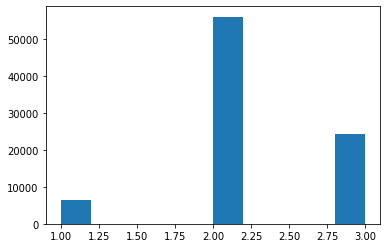

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y_pred)

In [ ]:
import pandas as pd
sub_csv = pd.read_csv("submission_format.csv")
sub_csv["damage_grade"] = y_pred
sub_csv.to_csv("submission.csv", index=False)

# Investigating model state